In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
from griddedoutput_helperfuncs import *
from griddedoutput_plotting import *

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def processCrossSection(data_path, xstart, xend, ystart, yend, z_idx, t_idx):

    xwidth = xend-xstart + 1
    ywidth = yend-ystart + 1

    crosssec_aero_diams = np.array([])
    crosssec_aero_masses = np.zeros((20, 1))
    crosssec_aero_numconc = np.array([])

    crosssec_aero_component_start_ind = np.zeros((xwidth, ywidth)).astype(int)
    cell_start_idx = 0
    for x_idx in np.arange(xwidth):
        for y_idx in np.arange(ywidth):
            x_cell = xstart + x_idx
            y_cell = ystart + y_idx
            filename = f'gridded-output_{str(x_cell).zfill(3)}_{str(y_cell).zfill(3)}_{str(t_idx).zfill(8)}.nc'

            data = nc.Dataset(os.path.join(data_path, filename))

            # Retreive aerosol particle array indices for vertical level
            start_idx, end_idx = getVertGridCellPartIndices(data, z_idx)

            # Aerosol Diameters
            particle_diameters = getParticleDiameters(data)
            cell_part_diams = particle_diameters[start_idx:end_idx]
            #print(cell_part_diams[:1])
            # Store the aerosol particle diameters in a 1D array for the specified vertical level
            crosssec_aero_diams = np.append(crosssec_aero_diams, cell_part_diams)

            # Aerosol Masses
            cell_part_masses = data['aero_particle_mass'][:, start_idx:end_idx] # constituent masses of each aerosol particle
            #print(cell_part_masses[:, :1][0])
            # Store the aerosol particle masses in a 20 X N for the specified vertical level (N total number of aerosol particles in the level)
            # 20 constituent species masses in each aerosol particle
            crosssec_aero_masses = np.append(crosssec_aero_masses, cell_part_masses, axis=1)

            # Aerosol number concentration
            cell_aero_numconc = data['aero_num_conc'][start_idx:end_idx]
            crosssec_aero_numconc = np.append(crosssec_aero_numconc, cell_aero_numconc)

            # Store location to the starting index for the aerosol particle in each grid cell (dimensions nx x ny for accessing aerosol particles in each cell)
            crosssec_aero_component_start_ind[x_idx, y_idx] = cell_start_idx
            cell_start_idx  = cell_start_idx + (end_idx-start_idx)

    crosssec_aero_masses = crosssec_aero_masses[:, 1:] # need to remove the first element since array of zeros used as placeholder 

    return crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses

def loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx, verbose=True):
    slurmid = sim_dict[scenario]
    output_path = '/data/nriemer/d/sf20/les_output/wrf-partmc'
    output_subdir = os.path.join(output_path, f'slurm-{slurmid}')

    if os.path.isfile(f'./crosssec_data/crosssec_{scenario}_t{t_idx}_z{z_idx}.nc'):
        if verbose:
            print('Loading file')
        crosssec_data = nc.Dataset(f'./crosssec_data/crosssec_{scenario}_t{t_idx}_z{z_idx}.nc', 'r', format='NETCDF4')
        # load the environmental variables
        crosssec_aero_diams = crosssec_data['aero_diams'][:]
        crosssec_aero_numconc = crosssec_data['aero_numconc'][:]
        crosssec_aero_masses = crosssec_data['aero_masses'][:]

        crosssec_data.close()
    else:
        if verbose:
            print('File does not exist, processing data')
        data_tuple = processCrossSection(output_subdir, xstart, xend, ystart, yend, z_idx, t_idx)
        crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses = data_tuple

        history_dt = 1 # hours
        time =  (t_idx-1)*history_dt
        processed_data = nc.Dataset(f'./crosssec_data/crosssec_{scenario}_t{t_idx}_z{z_idx}.nc', 'w', format='NETCDF4')
        processed_data.description = f'Processed cross-section simulation data at time = {time} hr, zlevel = {z_idx}'
        # dimensions
        #time_dim_size = 7
        #processed_data.createDimension('time', time_dim_size)
        n_particles = crosssec_aero_diams.size
        processed_data.createDimension('n_particles', n_particles) #NOTE the issue with this approach is that the number of particle changes with time.
        n_species = len(aero_species)
        processed_data.createDimension('n_species', n_species)
        aero_diams = processed_data.createVariable('aero_diams', 'f8', ('n_particles'))
        aero_numconc = processed_data.createVariable('aero_numconc', 'f8', ('n_particles'))
        aero_masses = processed_data.createVariable('aero_masses', 'f8', ('n_species', 'n_particles'))
        
        # variables
        aero_diams[:] = crosssec_aero_diams
        aero_numconc[:] = crosssec_aero_numconc
        aero_masses[:] = crosssec_aero_masses

        processed_data.close()
    
    return crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses

In [4]:
#output_subdir = output_path # temporary while simulation running
# point-source-10x10 test run: 1904245

# NOTE: USER SELECT SCENARIO
scenario = 'basecase'

z_idx = 40 # 0 indexing
t_idx = 7 # 1 indexing
xstart, ystart = 1, 1 # 1 indexing
xend, yend = 40, 40 # 1 indexing

history_dt = 1 # hours
time =  (t_idx-1)*history_dt
xwidth = xend-xstart + 1
ywidth = yend-ystart + 1
n_total_cells = xwidth*ywidth

data_tuple = loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)
crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses = data_tuple

Loading file


0

In [10]:
sulfate = crosssec_aero_masses[aero_species.index('SO4'), :]
nitrate = crosssec_aero_masses[aero_species.index('NO3'), :]
ammonium = crosssec_aero_masses[aero_species.index('NH4'), :]

In [11]:
sna_ratio = (ammonium - 2*sulfate )/ nitrate

In [14]:
sna_ratio.max()

0.2537603958439017

Plot the mean number distribution across the vertical layer

In [ ]:
crosssec_mean_num_dist_optimized = getNumberDistOptimized(particle_diam_arr=crosssec_aero_diams, particle_numconc_arr=crosssec_aero_numconc, n_grid_cells=n_total_cells)

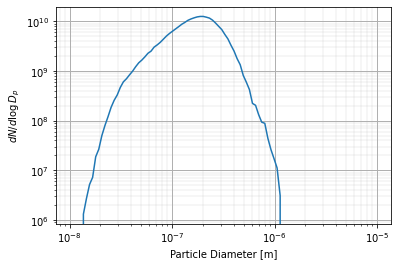

In [5]:
plotNumberDist(crosssec_mean_num_dist_optimized, plot_type='line', 
               #ylims=(1e6, 1e11)
               )

Plot the number distribution for each hour on the same figure (requires loading in NetCDF datasets)

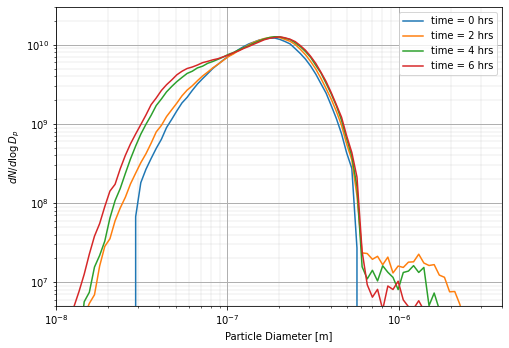

In [40]:
scenario = 'point-source-10x10'

z_idx = 40 # 0 indexing
#t_idx = 7 # 1 indexing
xstart, ystart = 1, 1 # 1 indexing
xend, yend = 40, 40 # 1 indexing

history_dt = 1 # hours
#time =  (t_idx-1)*history_dt
xwidth = xend-xstart + 1
ywidth = yend-ystart + 1
n_total_cells = xwidth*ywidth

colors = plt.get_cmap('tab10')(np.linspace(0, 1, 10))
fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
times = np.arange(1, 8, 2)#np.arange(1, 8, 1)
for t, c in zip(times, colors):
    data_tuple = loadData(scenario, xstart, xend, ystart, yend, z_idx, t, verbose=False)
    crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses = data_tuple
    crosssec_mean_num_dist_optimized = getNumberDistOptimized(particle_diam_arr=crosssec_aero_diams, particle_numconc_arr=crosssec_aero_numconc, n_grid_cells=n_total_cells)
    ax = plotNumberDist(crosssec_mean_num_dist_optimized, plot_type='line', ax=ax, color=c, label=f'time = {t-1} hrs',
                        #yscale='linear'
                        #ylims=(1e6, 1e11)
                        xlims=(1e-8, 4e-6),
                    ylims=(5e6, 3e10)
                        )


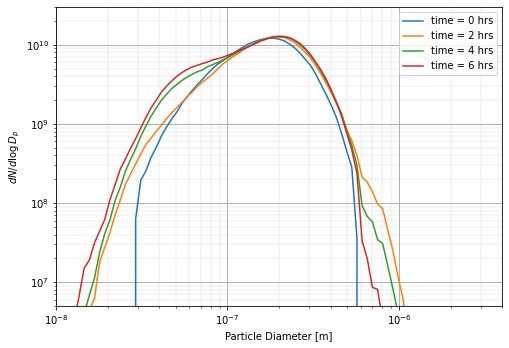

In [39]:
scenario = 'basecase'

z_idx = 40 # 0 indexing
xstart, ystart = 1, 1 # 1 indexing
xend, yend = 40, 40 # 1 indexing

history_dt = 1 # hours
time =  (t_idx-1)*history_dt
xwidth = xend-xstart + 1
ywidth = yend-ystart + 1
n_total_cells = xwidth*ywidth

colors = plt.get_cmap('tab10')(np.linspace(0, 1, 10))
fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
times = np.arange(1, 8, 2)#np.arange(1, 8, 1)
for t, c in zip(times, colors):
    data_tuple = loadData(scenario, xstart, xend, ystart, yend, z_idx, t, verbose=False)
    crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses = data_tuple
    crosssec_mean_num_dist_optimized = getNumberDistOptimized(particle_diam_arr=crosssec_aero_diams, particle_numconc_arr=crosssec_aero_numconc, n_grid_cells=n_total_cells)
    ax = plotNumberDist(crosssec_mean_num_dist_optimized, plot_type='line', ax=ax, color=c, label=f'time = {t-1} hrs',
                        #yscale='linear'
                        #ylims=(1e6, 1e11)
                        xlims=(1e-8, 4e-6),
                        ylims=(5e6, 3e10)
                        )


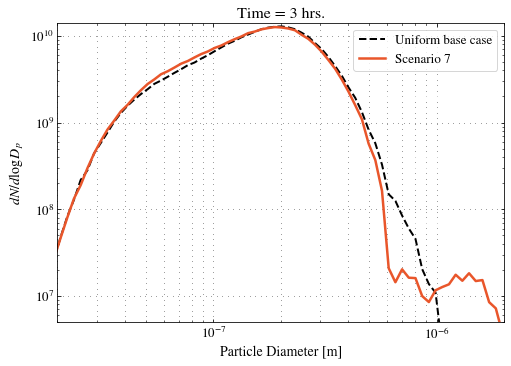

In [26]:
scenario = 'basecase'

z_idx = 40 # 0 indexing
xstart, ystart = 1, 1 # 1 indexing
xend, yend = 40, 40 # 1 indexing

history_dt = 1 # hours
time =  (t_idx-1)*history_dt
xwidth = xend-xstart + 1
ywidth = yend-ystart + 1
n_total_cells = xwidth*ywidth

fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
t = 4
data_tuple = loadData(scenario, xstart, xend, ystart, yend, z_idx, t, verbose=False)
crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses = data_tuple
crosssec_mean_num_dist_optimized = getNumberDistOptimized(particle_diam_arr=crosssec_aero_diams, particle_numconc_arr=crosssec_aero_numconc, n_grid_cells=n_total_cells)
ax = plotNumberDist(crosssec_mean_num_dist_optimized, plot_type='line', ax=ax, color='k', label='Uniform base case',
                    #yscale='linear',
                    xlims=(2e-8, 1.5e-6),
                    ylims=(5e6, 1.4e10),
                    lw=2, ls='--',
                    legend_fontsize=13
                    )

bc_sum = crosssec_mean_num_dist_optimized[bin_geocenter>1e-7].sum()

scenario = 'point-source-10x10'
data_tuple = loadData(scenario, xstart, xend, ystart, yend, z_idx, t, verbose=False)
crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses = data_tuple
crosssec_mean_num_dist_optimized = getNumberDistOptimized(particle_diam_arr=crosssec_aero_diams, particle_numconc_arr=crosssec_aero_numconc, n_grid_cells=n_total_cells)
ax = plotNumberDist(crosssec_mean_num_dist_optimized, plot_type='line', ax=ax, color='#E9562B', label='Scenario 7',
                    #yscale='linear',
                    xlims=(2e-8, 2e-6),
                    ylims=(5e6, 1.4e10),
                    lw=2.5, ls='-',
                    legend_fontsize=13
                    )
ax.set_title(f'Time = {int(t-1)} hrs.', fontsize=16)
ax.set_ylabel('$dN / d\log{D_p}$', fontsize=14)
ax.set_xlabel('Particle Diameter [m]', fontsize=14)

ax.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,5), c='#414141')
ax.grid(which = "minor", linewidth = 1, axis='y', ls="dotted", dashes=(.5,5), c='white')
ax.grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,5), c='#414141')
ax.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,5), c='#414141')
ax.tick_params(axis='both', labelsize=13, which='major', direction='in', top=True, right=True, bottom=True, left=True)
ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

#plt.savefig(f'size-dist-snapshot.pdf', format='pdf', bbox_inches='tight')


In [32]:
(ps_sum - bc_sum)/bc_sum

-0.019449111010992257

Text(0.5, 1.0, 'Number Conc Bias: Point-source - Base case (time = 1 hr)')

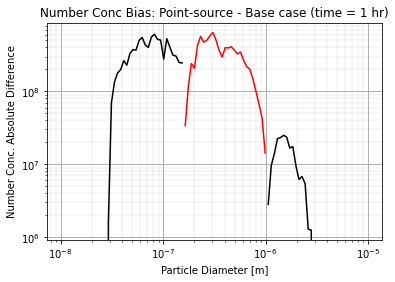

In [27]:
fig, ax = plt.subplots(1, 1)
for t in [2]:
    data_tuple = loadData('basecase', xstart, xend, ystart, yend, z_idx, t, verbose=False)
    crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses = data_tuple
    basecase_numdist = getNumberDistOptimized(particle_diam_arr=crosssec_aero_diams, particle_numconc_arr=crosssec_aero_numconc, n_grid_cells=n_total_cells)

    data_tuple = loadData('point-source-10x10', xstart, xend, ystart, yend, z_idx, t, verbose=False)
    crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses = data_tuple
    pointsource_numdist = getNumberDistOptimized(particle_diam_arr=crosssec_aero_diams, particle_numconc_arr=crosssec_aero_numconc, n_grid_cells=n_total_cells)

    diff = (pointsource_numdist - basecase_numdist)
    ax.plot(bin_geocenter, np.where(diff>0, np.nan, abs(diff)), c='r')
    ax.plot(bin_geocenter, np.where(diff<0, np.nan, abs(diff)), c='k')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Number Conc. Absolute Difference')
ax.set_xlabel('Particle Diameter [m]')
plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.2)
plt.minorticks_on()
plt.title(f'Number Conc Bias: Point-source - Base case (time = {t-1} hr)')


Confirming that the former method for computing the number concentration is equivalent to `scipy.binned_statistic` approach

In [ ]:
"""
crosssec_mean_num_dist_optimized = getNumberDistOptimized(particle_diam_arr=crosssec_aero_diams, particle_numconc_arr=crosssec_aero_numconc, n_grid_cells=n_total_cells)

bin_width = bin_edges[1:] - bin_edges[:-1] 

plt.bar(x=bin_geocenter, height=crosssec_mean_num_dist_optimized, width=bin_width, alpha=.6)
plt.xscale('log')
plt.yscale('log')
plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.2)
plt.minorticks_on()

crosssec_mean_num_dist = getNumberDist(particle_diam_arr=crosssec_aero_diams, particle_numconc_arr=crosssec_aero_numconc, n_grid_cells=n_total_cells)
plotNumberDist(crosssec_mean_num_dist, #ylims=(1e6, 1e11)
               )
plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.2)
plt.minorticks_on()

max(crosssec_mean_num_dist_optimized -crosssec_mean_num_dist)
"""

Plot the mean speciated mass distribution across the vertical layer

In [38]:
crosssec_binned_mean_species_mass_optimized =  getBinnedSpeciesMassOptimized(crosssec_aero_diams, crosssec_aero_masses, crosssec_aero_numconc, n_grid_cells=n_total_cells)

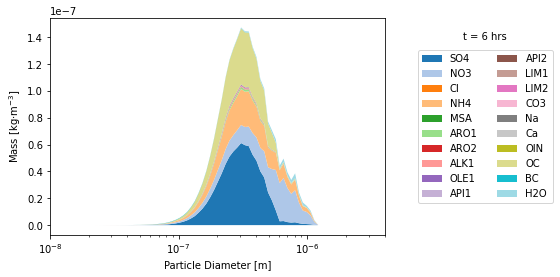

In [40]:
plotSpeciatedMassDist(crosssec_binned_mean_species_mass_optimized, yscale='linear', 
                      xlims=(1e-8, 4e-6), time=time, savefig=False
                      )

10


/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/griddedoutput_plotting.py:83: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin


40
50


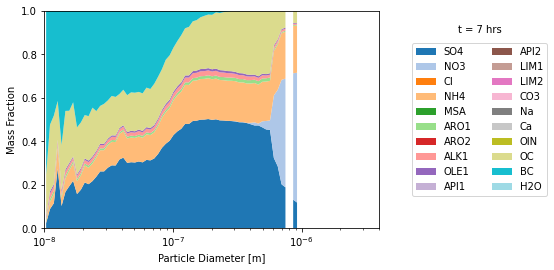

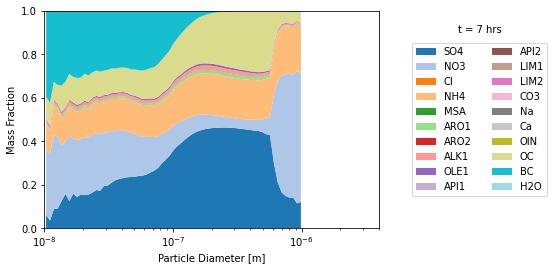

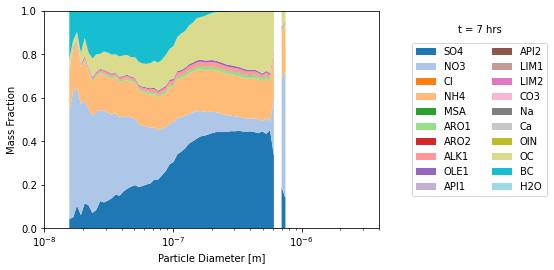

In [11]:
for z in [10, 40, 50]:
    data_tuple = loadData(scenario, xstart, xend, ystart, yend, z, t_idx=7, verbose=False)
    crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses = data_tuple
    crosssec_binned_mean_species_mass_optimized =  getBinnedSpeciesMassOptimized(crosssec_aero_diams, crosssec_aero_masses, crosssec_aero_numconc, n_grid_cells=n_total_cells)
    print(z)
    plotSpeciatedMassFrac(crosssec_binned_mean_species_mass_optimized, xlims=(1e-8, 4e-6), 
                      time=7, savefig=False)

Confirm that former method for calculating mass distribution is equivalent

In [17]:
#crosssec_binned_mean_species_mass = getBinnedSpeciesMass(crosssec_aero_diams, crosssec_aero_masses, crosssec_aero_numconc, n_grid_cells=n_total_cells)
#rel_bias = abs(crosssec_binned_mean_species_mass[:, :-1] - crosssec_binned_mean_species_mass_optimized)/crosssec_binned_mean_species_mass[:, :-1]
# confirm methods are equivalent 
#np.nansum(rel_bias)

Plot the speciated mass fraction

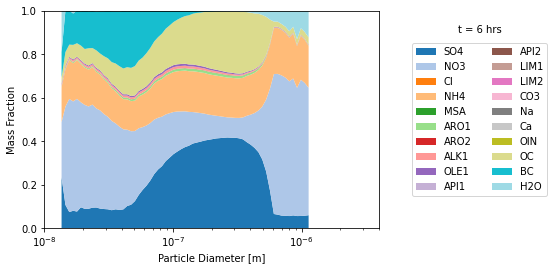

In [39]:
plotSpeciatedMassFrac(crosssec_binned_mean_species_mass_optimized, xlims=(1e-8, 4e-6), 
                      time=time, savefig=False)

Make speciated mass distribution and mass fraction plots for the basecase

In [6]:
#scenario = 'basecase'
scenario = 'point-source-10x10'

z_idx = 40 # 0 indexing
#t_idx = 3 # 1 indexing
xstart, ystart = 1, 1 # 1 indexing
xend, yend = 40, 40 # 1 indexing

history_dt = 1 # hours
#time =  (t_idx-1)*history_dt
xwidth = xend-xstart + 1
ywidth = yend-ystart + 1
n_total_cells = xwidth*ywidth

#colors = plt.get_cmap('tab10')(np.linspace(0, 1, 10))
#fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
for t in np.arange(1, 8, 1):
    data_tuple = loadData(scenario, xstart, xend, ystart, yend, z_idx, t, verbose=False)
    crosssec_aero_diams, crosssec_aero_numconc, crosssec_aero_masses = data_tuple
    crosssec_binned_mean_species_mass_optimized =  getBinnedSpeciesMassOptimized(crosssec_aero_diams, crosssec_aero_masses, crosssec_aero_numconc, n_grid_cells=n_total_cells)

    plotSpeciatedMassDist(crosssec_binned_mean_species_mass_optimized, yscale='linear', 
                      xlims=(1e-8, 4e-6), time=t-1, savefig=True, scenario=scenario
                      )
    plt.close()

    plotSpeciatedMassFrac(crosssec_binned_mean_species_mass_optimized, xlims=(1e-8, 4e-6), 
                      time=t-1, savefig=True, scenario=scenario
                      )
    plt.close()

/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/griddedoutput_plotting.py:83: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin
/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/griddedoutput_plotting.py:83: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin
/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/griddedoutput_plotting.py:83: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin
/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/griddedoutput_plotting.py:83: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin
/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/griddedoutput_plotting.py:

Print variable names, dimensions, and descriptions

In [19]:
printGriddedOutputInfo(data)

process                      dimensions: ()           description: the process number (starting from 1) that output this data file  -  
total_processes              dimensions: ()           description: total number of processes  -  
time                         dimensions: ()           description: time elapsed since simulation start  -  
timestep                     dimensions: ()           description: current timestep size  -  
timestep_index               dimensions: ()           description: an integer that is 1 on the first timestep, 2 on the second timestep, etc.  -  
gas_species                  dimensions: (77,)        description: dummy dimension variable (no useful value) - read species names as comma-separated values from the 'names' attribute  -  
gas_mosaic_index             dimensions: (77,)        description: MOSAIC indices of gas species  -  
aero_species                 dimensions: (20,)        description: dummy dimension variable (no useful value) - read species n

In [16]:
# load in some arbitrary gridded output dataset for pulling species densities and kappa 
output_path = '/data/nriemer/d/sf20/les_output/wrf-partmc'
output_subdir = os.path.join(output_path, f'slurm-1909559')
filename = f'gridded-output_020_020_00000001.nc'
data = nc.Dataset(os.path.join(output_subdir, filename))

In [74]:
aero_density = data['aero_density']
aero_kappa = data['aero_kappa']

# volume fraction of each solid species (every species except last component which is water)
aero_solid_volume = (crosssec_aero_masses[:] /aero_density[:].data[:, np.newaxis]).data[:-1, :]

# sum up the volumes for all solid species 
aero_solid_total_volume = aero_solid_volume.sum(axis=0)

# volume fraction of each solid species
aero_solid_volume_frac = aero_solid_volume/aero_solid_total_volume

kappa = (aero_solid_volume_frac * aero_kappa[:].data[:-1, np.newaxis]).sum(axis=0)

In [82]:
values = kappa
sorting_variable = crosssec_aero_diams
# generate weighted binning of particles by diameter - sorted by diameter and the sum of number conc in 
# each bin is the resulting histogram value
bin_result, _ , binnumbers = stats.binned_statistic(sorting_variable, values, 'sum', bins=bin_edges)
kappa_dist = bin_result/bin_logwidth
kappa_dist = kappa_dist/n_total_cells


Text(0.5, 0, 'Particle Diameter [m]')

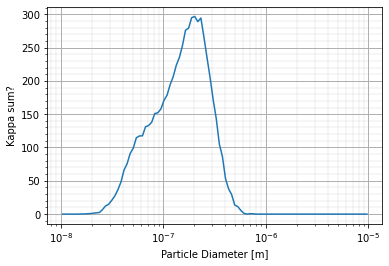

In [86]:
plt.plot(bin_geocenter, kappa_dist)
plt.xscale('log')
#plt.yscale('log')
plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.2)
plt.minorticks_on()
plt.ylabel('Kappa sum?')
plt.xlabel('Particle Diameter [m]')

(array([  159.,  1154.,  2416.,  3302.,  3676., 15647., 21353.,  7912.,
         2526.,   475.]),
 array([0.02193337, 0.0839435 , 0.14595362, 0.20796374, 0.26997386,
        0.33198398, 0.3939941 , 0.45600422, 0.51801434, 0.58002446,
        0.64203458]),
 <BarContainer object of 10 artists>)

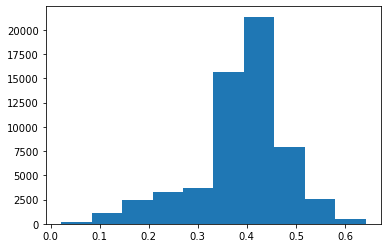

In [75]:
plt.hist(kappa)

In [40]:
# intercompare with coarse-resolution aerosol distribution data...
# Honestly I dont know if this is a fair comparison at the grid-cell to grid-cell 
# level since random perturbations may lead to different number of particles per 
# grid cell etc. Would need to average over a range of cells for a more appropriate 
# comparison.
i = xstart - 1
j = ystart - 1
k = z_idx 
t = t_idx - 1 #note that the history interval for the coarse resolved data is 5 mins

scenario = 'point-source-10x10'
dist_dict = {}
for dist_idx, dist_type in enumerate(['num', 'mass']):
    scenario_aerodata = aerodata_dict[scenario]['aerodata']
    scenario_distdata = aerodata_dict[scenario]['distdata']

    bin_vals = []
    bin_edges = scenario_distdata['BIN_EDGES'][:].data[0]#scenario_aerodata['BIN_EDGES'][:].data[0]
    bin_centers = scenario_distdata['BIN_CENTERS'][:].data[0]#scenario_aerodata['BIN_CENTERS'][:].data[0]
    bin_width = bin_edges[1:] - bin_edges[:-1]
    for bin_idx in range(100):
        bin_idx += 1 # 1 indexing 
        bin_data = scenario_distdata[f'{dist_type}_a{str(bin_idx).zfill(3)}'][t, k, j, i].data.item()#/1e6
        bin_vals.append(bin_data)
    dist_dict[dist_type] = np.array(bin_vals)
